Let's consider an observation-outcome sequence of the form $x_1, x_2, ..., x_m,z$ , where each $x_t$ is the an observation and  $z$ is the outcome.

For each observation $x_t$, the learner produces a prediction $P_t$ that is an approximation of $z$. These predictions also depend on a vector of modifiable parameters $w$, and can thus be written as $P(x_t, w)$

Let's assume for the moment the the parameter vector $w$ is __updated at the end__ of the sequence. Thus,  for each observation, we compute an icrement $\Delta w_t$ and at the end of the sequence $w$ will be changed by the sum of all the computed increments:

$$ w \leftarrow w + \sum_{t=1}^m \Delta w_t \quad (1)$$

<h1>__Supervised learning__</h1> 

treats each sequence $x_1,...,x_m,z$ as a sequence of observation-outcome pairs $(x_1,z),(x_2,z),...,(x_m,z)$. The increment $\Delta w_t$ will depend on the error between $P_t$ and $z$; in particular:

$$ \Delta w_t = \alpha(z - P_t)\nabla_w P_t \quad (2)$$

The important thing to notice is that $\Delta w_t$ always depends on $z$, and thus cannot be computed until the end of the sequence, when $z$ becomes known.



<h1>__TD(1)__</h1>

produces exactly the same result as (2), but can be computed incrementally. In fact we can consider the error $$z - P_t$$ as the sum of changes in predictions during steps following $t$, that is:

$$ z-P_t = \sum_{k=t}^m (P_{k+1} - P_k), \quad with ~ P_{m+1} = z$$

then, through algebric manipulations, 


$$ w \leftarrow w + \sum_{t=1}^m  \alpha(z - P_t)\nabla_w P_t = w+ \sum_{t=1}^m \alpha(P_{t+1} - P_t) \sum_{k=1}^t\nabla_wP_k   $$

and thus

$$ \Delta w_t = \alpha(P_{t+1} - P_t) \sum_{k=1}^t\nabla_wP_k \quad (3) $$

<h1>__TD($\lambda$)__</h1>

generalizes (3), making greater alterations to more recent predictions. In particular, alterations of past predictions are weighted exponentially. An important thing to notice is that this weighting form can be computed incrementally, in fact:

$$ \Delta w_t = \alpha(P_{t+1} - P_t) \sum_{k=1}^t\lambda^{t-k} \nabla_wP_k \quad $$ 
where
$$ \sum_{k=1}^t\lambda^{t-k} \nabla_wP_k = e_t$$

and 

$$ e_{t+1} = \sum_{k=1}^{t+1}\lambda^{t+-k} \nabla_wP_k \\
= \nabla_w P_{t+1} + \lambda e_t$$

## Experiments

We consider a random walk made of 5 states, starting always from the middle state, that at each step can move either left or right with equal probability. Each walk can end on the right node with reward +1 or at the left node with reward -1. For each state, we want to estimate the probability of terminating at the right end from it

100 training set, each made of 10 random sequences, have been constructed in order to evaluate the learning algorithms 

<img src='images/Capture.PNG'> 

In the first experiment, we present each training set until convergence. The parameter vector is updated after all the sequences of a training set have been processed.

In [72]:
import numpy as np
import matplotlib.pyplot as plt

In [73]:
%matplotlib inline

In [74]:
class bounded_random_walk(object):
    
    def __init__(self):
        self.states = np.eye(5)
    
    def get_start(self):
        return 2
    
    def state_vector(self,state):
        return self.states[state]
    
    def get_next(self,state):
        #left
        if np.random.binomial(1,0.5):
            return state-1
        #right
        else:
            return state+1
    
    def is_terminal(self, state):
        return state==-1 or state==5
    
    def get_outcome(self, state):
        if state == -1:
            return 0
        elif state==5:
            return 1
        else:
            print("Error: outcome defined only for terminal states")
            raw_input("Pausa")
            return -1

In [75]:
walk = bounded_random_walk()

In [76]:
true_w = np.array([1./6, 1./3,1./2,2./3,5./6])

In [77]:
## Build training set
episodes = []
for run in range(100):
    trainset = []
    for i in range(10):
        e = []
        state = walk.get_start()
        e.append(state)
        while (not walk.is_terminal(state)):
            nextState = walk.get_next(state)
            e.append(nextState)
            state = nextState
        trainset.append(e)
    episodes.append(trainset)

In [78]:
from IPython.display import clear_output
import sys

In [79]:
l_list = [0. ,0.1, 0.3, 0.5, 0.7, 0.9, 1.] 

In [80]:
eps = 10**(-4)
alpha = 0.001


w_results = np.zeros((len(l_list), 100, 5))

for idx_l,l in enumerate(l_list):    
    for nb_trainset in range(100):
        clear_output()
        print (l)
        print (nb_trainset)
        sys.stdout.flush()
        w = np.zeros(5)
        delta = eps+1
        trainset = episodes[nb_trainset]
        while (delta > eps):
            delta = 0
            delta_w = 0
            for e in range(10):
                episode = trainset[e]    
                et = 0
                for idx, state in enumerate(episode):            
                    if (walk.is_terminal(state)):
                        break
                    nextState = episode[idx+1]

                    phi_state     = walk.state_vector(state)
                    Pt  = phi_state.dot(w)

                    if (walk.is_terminal(nextState)):
                        Pt1 = walk.get_outcome(nextState)
                    else:
                        phi_nextState = walk.state_vector(nextState)
                        Pt1 = phi_nextState.dot(w)   
                    
                    et = l*et + phi_state
                    delta_w += alpha * (Pt1 - Pt) * et

            delta = np.max(delta_w)
            w += delta_w
        w_results[idx_l,nb_trainset,:] = w

1.0
99


In [81]:
def rmse(w):
    return np.sqrt(np.mean((true_w-w)**2))

In [82]:
errors = np.zeros((len(l_list),100))
for idx_l,_ in enumerate(l_list):
    for idx_trainset in range(100):
        errors[idx_l,idx_trainset] = rmse(w_results[idx_l,idx_trainset])

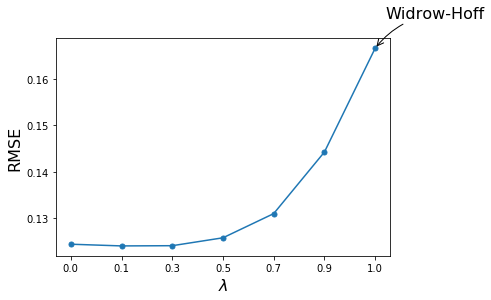

In [83]:
errors_avg = np.mean(errors, axis=1)
plt.plot(range(len(l_list)), errors_avg, marker='.', markersize ='10')
plt.xlabel(r'$\lambda$', fontsize=16)
plt.ylabel('RMSE', fontsize=16)
plt.xticks(range(7), [0. ,0.1, 0.3, 0.5, 0.7, 0.9, 1.])
plt.annotate('Widrow-Hoff',
             xy=(6, errors_avg[-1]), xycoords='data',
             xytext=(+10, +30), textcoords='offset points', fontsize=16,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))


plt.show()


As we can see, the error decreases as $\lambda$ becomes smaller. In fact, Widorw-Hoff algorithm only minimizes the Mean Squared Error between the predictions and the actual outcomes in the training set, it doesn't necessary minimizes the error on future experience. TD(0), instead, converges to the maximum likelihood estimates of the undrlying Markov process

In order to confirm that above observation, we compute the training set error for various values of $\lambda$

In [84]:
def rmse_trainset(idx_l, idx_trainset):
    w_final = w_results[idx_l, idx_trainset]
    trainset= episodes[idx_trainset]
    SE    = 0
    nbObs = 0
    for episode in trainset:
        ep_return = walk.get_outcome(episode[-1])
        for state in episode:
            if walk.is_terminal(state):
                continue
            SE   += (w_final[state] - ep_return)**2
            nbObs+= 1
        
    return np.sqrt(float(SE)/nbObs)

In [85]:
errors_train = np.zeros((7, 100))
for idx_l in range(7):
    for idx_trainset in range(100):
        errors_train[idx_l, idx_trainset] = rmse_trainset(idx_l, idx_trainset)

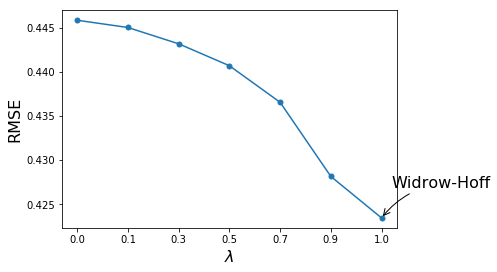

In [86]:
errors_train_avg = np.mean(errors_train, axis=1)
plt.plot(range(len(l_list)), errors_train_avg, marker='.', markersize ='10')
plt.xlabel(r'$\lambda$', fontsize=16)
plt.ylabel('RMSE', fontsize=16)
plt.xticks(range(7), [0. ,0.1, 0.3, 0.5, 0.7, 0.9, 1.])
plt.annotate('Widrow-Hoff',
             xy=(6, errors_train_avg[-1]), xycoords='data',
             xytext=(+10, +30), textcoords='offset points', fontsize=16,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))


plt.show()

The graph above confirms, as we expected, that Widrow-Hoff minimizes the error on the training set

We finally want to investigate the effect of  $\lambda $ and  $\alpha $ in the case where each training set is presented only once and the parameter vector is updated after each sequence

In [61]:
alpha_values = np.arange(0, 0.7, 0.05)
w_results = np.zeros((4, alpha_values.shape[0], 100, 5 ))
l_list = [0, 0.3, 0.8, 1]

for idx_l in range(4):
    clear_output()
    print (idx_l)
    l = l_list[idx_l]
    for idx_alpha in range(alpha_values.shape[0]):
        alpha = alpha_values[idx_alpha]
        for idx_trainset in range(100):
            trainset = episodes[idx_trainset]
            w = np.ones(5)*0.5
            for e in range(10):
                episode = trainset[e]    
                et = 0                
                delta_w = 0
                for idx, state in enumerate(episode):            
                    if (walk.is_terminal(state)):
                        break
                    nextState = episode[idx+1]

                    phi_state     = walk.state_vector(state)
                    Pt  = phi_state.dot(w)

                    if (walk.is_terminal(nextState)):
                        Pt1 = walk.get_outcome(nextState)
                    else:
                        phi_nextState = walk.state_vector(nextState)
                        Pt1 = phi_nextState.dot(w)   
                    
                    et = l*et + phi_state
                    delta_w += alpha * (Pt1 - Pt) * et                    

                w += delta_w
            w_results[idx_l, idx_alpha, idx_trainset] = w

3


In [62]:
errors = np.zeros((4, alpha_values.shape[0], 100))
for idx_l in range(4):
    for idx_alpha in range(alpha_values.shape[0]):
        for idx_trainset in range(100):
            errors[idx_l, idx_alpha, idx_trainset] = rmse(w_results[idx_l, idx_alpha, idx_trainset])

In [63]:
errors_avg = errors.mean(axis=2)

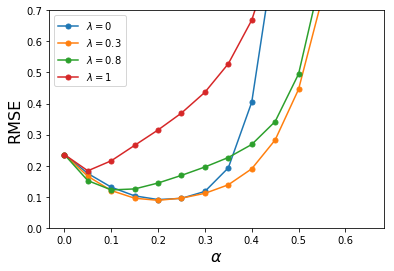

In [68]:
for idx_l in range(4):
    plt.plot(alpha_values, errors_avg[idx_l], label=r'$\lambda=$' + str(l_list[idx_l]), marker= '.', markersize=10)
plt.legend(loc='upper left')
plt.ylim(0,0.7)
plt.xticks(np.arange(0,0.7,0.1))
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel('RMSE', fontsize=16)
plt.show()